- 7 classes of documents
- 20 docs/class labeled
- features/document: 1433 words, an undirected graph where each doc is a node and citations = edges
- classify documents

Resources
---------
* Dataset: https://graphsandnetworks.com/the-cora-dataset/
* Intro videos, only 20 min total: https://www.youtube.com/watch?v=XRHhtLgpXqg and https://www.youtube.com/watch?v=Zjx25h8DnIo
* very good, concise blog post by author of paper: https://tkipf.github.io/graph-convolutional-networks/
* paper github repo https://github.com/tkipf/gcn/blob/master/gcn/train.py
* GCN Tutorial: https://antonsruberts.github.io/graph/gcn/
* node2vec video (8 min): https://www.youtube.com/watch?v=KM28WYkIiOg

In [ ]:
# Load data, only need to run once
!mkdir data
!curl https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -o data/cora.tgz
!tar -xzf ./data/cora.tgz -C ./data/
!rm ./data/cora.tgz

In [3]:
from typing import Tuple
from stellargraph.data import BiasedRandomWalk
import pandas as pd
from sklearn import model_selection
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import stellargraph as sg
from stellargraph.layer.gcn import GraphConvolution, GatherIndices
from stellargraph.data import BiasedRandomWalk

## Question 23

In [4]:
def load_cora_dataset(directory: str) -> Tuple[pd.DataFrame, sg.StellarGraph]:
    """Loads the Cora dataset

    Parameters
    ----------
    directory : str
        Directory where the dataset is stored

    Returns
    -------
    node_data: pd.DataFrame
        Dataframe containing the node features
    graph: sg.StellarGraph
        Graph containing the edges
    """
    edgelist = pd.read_csv(directory + '/cora.cites', sep='\t', header=None, names=["target", "source"])
    column_names = [f"w_{i}" for i in range(1433)] + ["subject"]
    node_data = pd.read_csv(directory + '/cora.content', sep='\t', header=None, names=column_names)
    node_data['subject'] = pd.Categorical(node_data.subject).codes

    # Nodes have weird values like 11573 when there are only 2708 nodes. We map them to [0,2708]
    node_mapping = dict(zip(node_data.index, np.arange(len(node_data.index))))
    edgelist['target'] = edgelist['target'].map(node_mapping)
    edgelist['source'] = edgelist['source'].map(node_mapping)
    node_data.index = node_data.index.map(node_mapping)

    graph  = sg.StellarGraph(node_data, edgelist)

    return node_data, graph


class GCN:
    """Graph Convolutional Network Model
    
    Attributes
    ----------
    model : tensorflow.keras.Model

    Methods
    -------
    fit()
        Fit the model to the data
    predict()
        Predict the class of the nodes
    evaluate()
        Evaluate the model on the test data and print test loss and accuracy
    """
    
    def __init__(self,
        n_features: int,
        n_nodes: int,
        kernel_initializer="glorot_uniform", 
        bias_initializer="zeros",
        layer1_size: int=32,
        layer2_size: int=32,
        input_dropout: float=0.9,
        hidden_dropout: float=0.5,
        epochs=20,
        batch_size=1,
        early_stopping=10,
        learning_rate=1e-2,
        weight_decay=5e-4,
    ):
        """Initialise the GCN model
        
        Parameters
        ----------
        kernel_initializer : str, default="glorot_uniform"
            Initializer for the weights matrix
        bias_initializer : str, default="zeros"
            Initializer for the bias vector
        layer1_size : int, optional
            Number of nodes in the first hidden layer, by default 32, if None, then no hidden layer
        layer2_size : int, optional
            Number of nodes in the second hidden layer, by default 32, if None, then no hidden layer
        input_dropout : float, default=0.9
            Dropout rate for the input layer
        hidden_dropout : float, default=0.5
            Dropout rate for the hidden layers
        epochs : int, default=20
            Number of epochs to train the model
        batch_size : int, default=1
            Batch size for training
        early_stopping : int, default=10
            Number of epochs to wait before early stopping
        learning_rate : float, default=1e-2
            Learning rate for the Adam optimizer
        weight_decay : float, default=5e-4
            Weight decay for the Adam optimizer
        """
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping

        # Build the model
        # Create input layer
        x_features = Input(batch_shape=(1, n_nodes, n_features))
        x_indices = Input(batch_shape=(1, None), dtype="int32")
        x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
        x_input  = [x_features, x_indices, x_adjacency]

        # Hidden Layers
        x = Dropout(input_dropout)(x_features)
        if layer1_size:
            x = GraphConvolution(
                layer1_size,
                activation='relu',
                use_bias=True,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
            )([x, x_adjacency])
            x = Dropout(hidden_dropout)(x)
        if layer2_size:
            x = GraphConvolution(
                layer2_size,
                activation='relu',
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer
            )([x, x_adjacency])
            x = GatherIndices(batch_dims=1)([x, x_indices])
        output = Dense(7, activation='softmax')(x)

        self.model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)

        # Compile model
        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
            loss=tf.losses.categorical_crossentropy,
            metrics=["acc"],
        )

    def fit(self, features_input, train_indices, A_input, y_train, y_val, val_indices):
        # Early stopping callback
        es_callback = EarlyStopping(monitor="val_acc", patience=self.early_stopping, restore_best_weights=True)

        # Train model
        history = self.model.fit(
            x = [features_input, train_indices, A_input],
            y = y_train,
            epochs=self.epochs,
            verbose=0,
            validation_data=([features_input, val_indices, A_input], y_val),
            shuffle=False,
            callbacks=[es_callback],
            batch_size=self.batch_size,
        )
        sg.utils.plot_history(history)
        
        return history

    def predict(self, features_input, test_indices, A_input):
        return self.model.predict([features_input, test_indices, A_input])

    def evaluate(self, features_input, test_indices, A_input, y_test) -> None:
        test_metrics = self.model.evaluate(
            x = [features_input, test_indices, A_input],
            y = y_test,
            verbose=0,
            batch_size=self.batch_size,
        )
        print(f"Test Set Metrics:\nLoss - {test_metrics[0]}\nAccuracy - {test_metrics[1]}")

In [6]:
node_data, graph = load_cora_dataset('./data/cora')

# Calculate Normalized Adjacency Matrix from GCN Paper
A      = graph.to_adjacency_matrix(weighted=False) # adjacency matrix
A_t    = A + np.eye(A.shape[0]) - A.diagonal() # add self-connections to each node
D_t    = np.diag(np.power(np.array(A_t.sum(axis=1)), -0.5)[:,0]) # symmetric normalization matrix
A_norm = D_t @ A @ D_t # normalized adjacency matrix

# Test/Train/Validation Split
train_nodes = []
for subject in node_data.subject.unique():
    train_nodes += node_data[node_data['subject'] == subject].sample(20).index.to_list()
test_nodes = list(set(node_data.index) - set(train_nodes))
test_nodes, val_nodes = model_selection.train_test_split(
    test_nodes, train_size=0.8, stratify=node_data.loc[test_nodes]['subject']
)

# Data Preprocessing
target_encoding = LabelBinarizer()
y_train = target_encoding.fit_transform(node_data.loc[train_nodes]['subject'])[None]
y_test = target_encoding.transform(node_data.loc[test_nodes]['subject'])[None]
y_val = target_encoding.transform(node_data.loc[val_nodes]['subject'])[None]

# Transorm dimensions to have a 1 at the start
features_input = node_data.to_numpy()[None]
A_input = A_norm[None]
train_indices = np.array(train_nodes)[None]
test_indices = np.array(test_nodes)[None]
val_indices = np.array(val_nodes)[None]

Test Set Metrics:
Loss - 0.5923418998718262
Accuracy - 0.8300876617431641


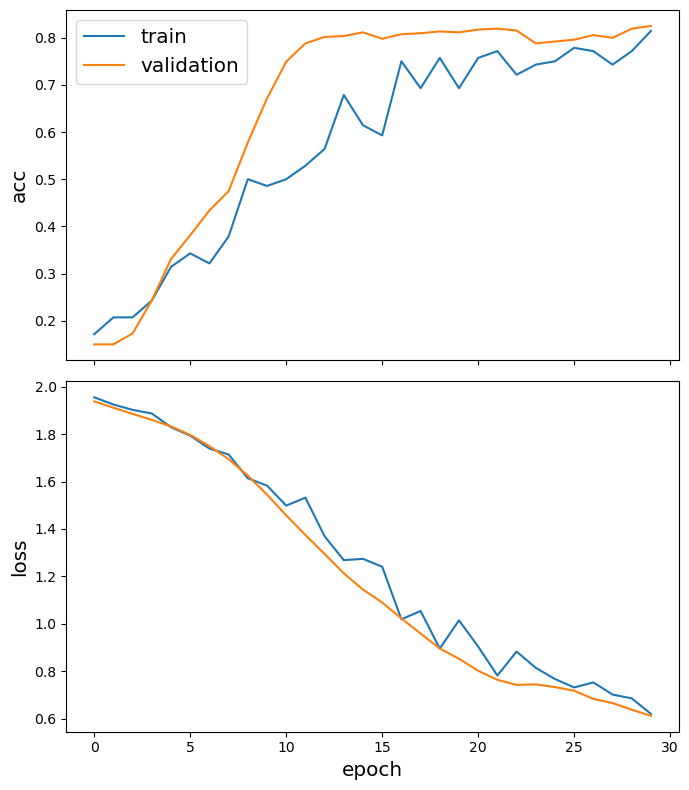

In [284]:
gcn = GCN(features_input.shape[2], features_input.shape[1], epochs=30)
gcn.fit(features_input, train_indices, A_input, y_train, y_val, val_indices)
gcn.evaluate(features_input, test_indices, A_input, y_test)

## Question 24

## Question 25